In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA, PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import operator
import time
import os
from random import shuffle

import random
from tqdm import trange
import PIL.Image as Image
from IPython import display

import warnings
warnings.simplefilter(action='ignore')

RANDOM_STATE = 42
%matplotlib inline

In [2]:
data = pd.read_csv('EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control/C002.csv', header = 1
                  ).rename(index=str, columns={'Saccade': 'Tracking type'})#.drop(0)
data['Duration'] = data['Duration'] - 1
data = data.replace(".", np.nan)

data["Start X"] = pd.to_numeric(data["Start X"])
data["Start Y"] = pd.to_numeric(data["Start Y"])
data['Start X'].min()
data.head(4)

,Tracking type,Trial Name,Eye,Start Time,End Time,Duration,Start X,Start Y,End X,End Y,Amplitude,Peak Velocity
0,Fixation,DadsArmy,L,1589991,1590718,727,772.7,575.1,797.0,NaN,NaN,NaN
1,Saccade,DadsArmy,L,1590719,1590756,37,770.1,583.3,735.1,472.1,2.85,186.0
2,Fixation,DadsArmy,L,1590757,1591033,276,732.2,486.0,786.0,NaN,NaN,NaN
3,Saccade,DadsArmy,L,1591034,1591055,21,733.4,482.8,643.2,460.1,2.28,196.0


In [3]:
path = 'EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)
clinic.shape[0]

76

In [4]:
path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()

In [5]:
path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Glaucoma'
control_path = path 
files_1 = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files = files + files_1
shuffle(files)
files

['G029.csv',
 'G012.csv',
 'G038.csv',
 'G021.csv',
 'G001.csv',
 'C006.csv',
 'G030.csv',
 'C027.csv',
 'G016.csv',
 'C029.csv',
 'G008.csv',
 'G020.csv',
 'C028.csv',
 'G025.csv',
 'G031.csv',
 'C018.csv',
 'C015.csv',
 'G013.csv',
 'G002.csv',
 'G039.csv',
 'C031.csv',
 'G036.csv',
 'G039.csv',
 'G009.csv',
 'G021.csv',
 'C013.csv',
 'C004.csv',
 'G029.csv',
 'G041.csv',
 'G011.csv',
 'G032.csv',
 'G014.csv',
 'C012.csv',
 'C005.csv',
 'G025.csv',
 'G033.csv',
 'G026.csv',
 'G010.csv',
 'G003.csv',
 'G008.csv',
 'G042.csv',
 'G004.csv',
 'G022.csv',
 'G030.csv',
 'C023.csv',
 'G018.csv',
 'G031.csv',
 'G017.csv',
 'G028.csv',
 'G040.csv',
 'G034.csv',
 'C032.csv',
 'C003.csv',
 'G041.csv',
 'G036.csv',
 'C011.csv',
 'G044.csv',
 'C008.csv',
 'G009.csv',
 'G040.csv',
 'G019.csv',
 'G043.csv',
 'G003.csv',
 'G013.csv',
 'G027.csv',
 'C009.csv',
 'C026.csv',
 'G014.csv',
 'G024.csv',
 'C016.csv',
 'C022.csv',
 'G019.csv',
 'G038.csv',
 'G007.csv',
 'C010.csv',
 'G037.csv',
 'C020.csv',

In [110]:
def make_hist_pupil(data,bins, min_diff):
    data = data.dropna()
    maximum = data['Pupil Area'].max()
    print(maximum)
    data['Pupil Area'] = data['Pupil Area'] / maximum
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))
    
    pupil_hist_DA = np.zeros(bins)
    pupil_hist_HB = np.zeros(bins)
    pupil_hist_SC = np.zeros(bins)
    
    for i in range(data_video_DA.shape[0]):
        if data_video_DA['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_DA[int((data_video_DA['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1
        
    for i in range(data_video_HB.shape[0]):
        if data_video_HB['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_HB[int((data_video_HB['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1        
    
    for i in range(data_video_SC.shape[0]):
        if data_video_SC['Pupil Area'].iloc[i] > min_diff:
            pupil_hist_SC[int((data_video_SC['Pupil Area'].iloc[i] - min_diff)*(bins - 1)/(1 - min_diff))] += 1    
    
    return pupil_hist_DA/data_video_DA.shape[0], pupil_hist_HB/data_video_HB.shape[0], pupil_hist_SC/data_video_SC.shape[0]

In [473]:
tv_diag = 54
y = np.sqrt(tv_diag**2*9/25)
x = np.sqrt(tv_diag**2*16/25)
view_dist = 60

angle_full_width_rad = np.arctan(x/2/view_dist)
angle_full_height_rad = np.arctan(y/2/view_dist)
angle_full_width_degr = angle_width_rad*180/np.pi
angle_full_height_degr = angle_height_rad*180/np.pi
print('angle_full_width = {:.3} radians = {:.3} degrees \nangle_full_height = {:.3} radians = {:.3} degrees'.
      format(angle_full_width_rad, angle_full_width_degr, angle_full_height_rad, angle_full_height_degr))

angle_part_width_degr = 17.3
angle_part_height_degr = 10.6

max_width_angle_deg = 12
max_height_angle_deg = 10
max_width_angle_rad = max_width_angle_deg * np.pi / 180
max_height_angle_rad = max_height_angle_deg * np.pi / 180
max_width = view_dist * np.tan(max_width_angle_rad)
max_height = view_dist * np.tan(max_height_angle_rad)
print('max_width = {:.3} sm \nmax_height = {:.3} sm'.format(max_width, max_height))

pixel_size = y/1200
print('pixel_size = {:.3} sm'.format(pixel_size))

angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm


In [1985]:
def make_density_map(data, min_saccade, n_rows, m_columns):
    data = data.dropna()
    size = 64
    dn = 2*size//n_rows + 1
    dm = 2*size//m_columns + 1
    data['delta X'] = (size-1) * data['delta X'] / max(data['delta X'].max(), -data['delta X'].min())
    data['delta Y'] = (size-1) * data['delta Y'] / max(data['delta Y'].max(), -data['delta Y'].min())

    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

    den_map_DA = np.zeros((n_rows, m_columns))
    den_map_HB = np.zeros((n_rows, m_columns))
    den_map_SC = np.zeros((n_rows, m_columns))

    for i in range(data_video_DA.shape[0]):
        if np.sqrt((data_video_DA['delta X'].iloc[i])**2 + (data_video_DA['delta Y'].iloc[i])**2) > min_saccade:
            den_map_DA[(size + int(data_video_DA['delta X'].iloc[i]) )// dn, (size + int(data_video_DA['delta Y'].iloc[i]))//dm] += 1
    
    for i in range(data_video_HB.shape[0]):
        if np.sqrt((data_video_HB['delta X'].iloc[i])**2 + (data_video_HB['delta Y'].iloc[i])**2) > min_saccade:
            den_map_HB[(size + int(data_video_HB['delta X'].iloc[i]) )// dn, (size + int(data_video_HB['delta Y'].iloc[i]))//dm] += 1

    for i in range(data_video_SC.shape[0]):
        if np.sqrt((data_video_SC['delta X'].iloc[i])**2 + (data_video_SC['delta Y'].iloc[i])**2) > min_saccade:
            den_map_SC[(size + int(data_video_SC['delta X'].iloc[i]) )// dn, (size + int(data_video_SC['delta Y'].iloc[i]))//dm] += 1
    
    return den_map_DA/data_video_DA.shape[0], den_map_HB/data_video_HB.shape[0], den_map_SC/data_video_SC.shape[0]

def make_picture(data, min_saccade, size): # drop one video 
    data = data.dropna()
    data['delta X'] = (size - 1) * data['delta X'] / max(data['delta X'].max(), - data['delta X'].min())
    data['delta Y'] = (size - 1) * data['delta Y'] / max(data['delta Y'].max(), - data['delta Y'].min())    
    
    data_video_DA = data.loc[data['Trial Name'] == 'DadsArmy']
    data_video_DA.set_index(np.arange(data_video_DA.shape[0]))
    
    data_video_HB = data.loc[data['Trial Name'] == 'HistoryBoys']
    data_video_HB.set_index(np.arange(data_video_HB.shape[0]))
    
    data_video_SC = data.loc[data['Trial Name'] == 'SkiCross']
    data_video_SC.set_index(np.arange(data_video_SC.shape[0]))

    picture_DA = 255* np.ones((2*size,2*size))
    picture_HB = 255* np.ones((2*size,2*size))
    picture_SC = 255* np.ones((2*size,2*size))
    
    for i in range(data_video_DA.shape[0]):
        if np.sqrt((data_video_DA['delta X'].iloc[i])**2 + (data_video_DA['delta Y'].iloc[i])**2) > min_saccade:
            picture_DA[size + int(data_video_DA['delta X'].iloc[i]), size + int(data_video_DA['delta Y'].iloc[i]) ] = 0 

    for i in range(data_video_HB.shape[0]):
        if np.sqrt((data_video_HB['delta X'].iloc[i])**2 + (data_video_HB['delta Y'].iloc[i])**2) > min_saccade:
            picture_HB[size + int(data_video_HB['delta X'].iloc[i]), size + int(data_video_HB['delta Y'].iloc[i]) ] = 0 

    for i in range(data_video_SC.shape[0]):
        if np.sqrt((data_video_SC['delta X'].iloc[i])**2 + (data_video_SC['delta Y'].iloc[i])**2) > min_saccade:
            picture_SC[size + int(data_video_SC['delta X'].iloc[i]), size + int(data_video_SC['delta Y'].iloc[i]) ] = 0 
    
    return picture_DA/data_video_DA.shape[0], picture_HB/data_video_HB.shape[0], picture_SC/data_video_SC.shape[0]

def fix_sac_sep_clean(tempdata):
    tempdata = tempdata.replace(".", np.nan)
    tempdata['Duration'] = tempdata['Duration'] - 1
    tempdata["Start X"] = pd.to_numeric(tempdata["Start X"])
    tempdata["Start Y"] = pd.to_numeric(tempdata["Start Y"])
    tempdata["End X"] = pd.to_numeric(tempdata["End X"])
    tempdata["End Y"] = pd.to_numeric(tempdata["End Y"])

    tempdata_suc = pd.DataFrame(tempdata.dropna().loc[tempdata['Tracking type'] == 'Saccade' ], columns=tempdata.columns)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Amplitude'] > 1000].index) # drop bad values
    tempdata_suc.index = np.arange(tempdata_suc.shape[0])
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] > 1600].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] > 1200].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start X'] < 1 ].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End X'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['Start Y'] < 1].index)
    tempdata_suc = tempdata_suc.drop(tempdata_suc.loc[tempdata_suc['End Y'] < 1].index)

    tempdata_fix = pd.DataFrame(tempdata.loc[tempdata['Tracking type'] == 'Fixation' ].values[:,:9], columns=[
        'Fixation', 'Trial Name', 'Eye', 'Start Time', 'End Time', 'Duration','X', 'Y', 'Pupil Area'])
    tempdata_fix['Start Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['End Time'] = pd.to_numeric(tempdata_fix['Start Time'])
    tempdata_fix['Duration'] = pd.to_numeric(tempdata_fix['Duration'])
    tempdata_fix['X'] = pd.to_numeric(tempdata_fix['X'])
    tempdata_fix['Y'] = pd.to_numeric(tempdata_fix['Y'])
    tempdata_fix['Pupil Area'] = pd.to_numeric(tempdata_fix['Pupil Area'])
    tempdata_fix.index = np.arange(tempdata_fix.shape[0])
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] > 1600].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] > 1200].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['X'] < 1].index)
    tempdata_fix = tempdata_fix.drop(tempdata_fix.loc[tempdata_fix['Y'] < 1].index)
    return tempdata_fix, tempdata_suc

features = ['Number of fix points per DadsArmy',
       'Number of sacs pers DadsArmy', 'Mean fix duration per DadsArmy',
       'Mean sac duration per DadsArmy', 'Mean Amplitude per DadsArmy',
       'Mean Peak Velocity per DadsArmy',
       'Fixatoin Trajectory Length DadsArmy',
       'Number of fix points per HistoryBoys',
       'Number of sacs pers HistoryBoys', 'Mean fix duration per HistoryBoys',
       'Mean sac duration per HistoryBoys', 'Mean Amplitude per HistoryBoys',
       'Mean Peak Velocity per HistoryBoys',
       'Fixatoin Trajectory Length HistoryBoys',
       'Number of fix points per SkiCross', 'Number of sacs pers SkiCross',
       'Mean fix duration per SkiCross', 'Mean sac duration per SkiCross',
       'Mean Amplitude per SkiCross', 'Mean Peak Velocity per SkiCross',
       'Fixatoin Trajectory Length SkiCross']

def make_dataset(files, features, path_read, path_write):
    dataset_DA = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[:len(features)//3])
    dataset_HB = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[len(features)//3:2*len(features)//3])
    dataset_SC = pd.DataFrame(np.zeros((len(files),len(features)//3)), columns = features[2*len(features)//3:])
    targets = []
    for index, f in enumerate(files): 
        tempdata = pd.read_csv(path_read + '/' + f, header = 1).rename(index=str, columns={'Saccade': 'Tracking type'})
        tempdata_fix, tempdata_suc = fix_sac_sep_clean(tempdata)
        # generating features from inner dataset (timeserias to features)

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'DadsArmy']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'DadsArmy']

        dataset_DA['Number of fix points per DadsArmy'].iloc[index] = data_ov_fix.shape[0]
        dataset_DA['Number of sacs pers DadsArmy'].iloc[index] = data_ov_suc.shape[0]
        dataset_DA['Mean fix duration per DadsArmy'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_DA['Mean sac duration per DadsArmy'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_DA['Mean Amplitude per DadsArmy'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_DA['Mean Peak Velocity per DadsArmy'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_DA['Fixatoin Trajectory Length DadsArmy'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'HistoryBoys']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'HistoryBoys']

        dataset_HB['Number of fix points per HistoryBoys'].iloc[index] = data_ov_fix.shape[0]
        dataset_HB['Number of sacs pers HistoryBoys'].iloc[index] = data_ov_suc.shape[0]
        dataset_HB['Mean fix duration per HistoryBoys'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_HB['Mean sac duration per HistoryBoys'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_HB['Mean Amplitude per HistoryBoys'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_HB['Mean Peak Velocity per HistoryBoys'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_HB['Fixatoin Trajectory Length HistoryBoys'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()

        data_ov_fix = tempdata_fix.loc[tempdata_fix['Trial Name'] == 'SkiCross']
        data_ov_suc = tempdata_suc.loc[tempdata_suc['Trial Name'] == 'SkiCross']

        dataset_SC['Number of fix points per SkiCross'].iloc[index] = data_ov_fix.shape[0]
        dataset_SC['Number of sacs pers SkiCross'].iloc[index] = data_ov_suc.shape[0]
        dataset_SC['Mean fix duration per SkiCross'].iloc[index] = data_ov_fix['Duration'].mean()
        dataset_SC['Mean sac duration per SkiCross'].iloc[index] = data_ov_suc['Duration'].mean()
        dataset_SC['Mean Amplitude per SkiCross'].iloc[index] = data_ov_suc['Amplitude'].mean()
        dataset_SC['Mean Peak Velocity per SkiCross'].iloc[index] = data_ov_suc['Peak Velocity'].mean()
        dataset_SC['Fixatoin Trajectory Length SkiCross'].iloc[index] = np.sqrt((data_ov_fix['X'].values[1:] - data_ov_fix['X'].values[0:-1])**2 +\
        (data_ov_fix['Y'].values[1:] - data_ov_fix['Y'].values[:-1])**2).sum()
        
        # relative saccade and diff of pupil size
        map_suc = np.zeros((tempdata_suc.shape[0],2))
        pupil_delta = np.zeros(tempdata_fix.shape[0])
        map_suc[:,0] = tempdata_suc['Start X'].values - tempdata_suc['End X'].values
        map_suc[:,1] = tempdata_suc['Start Y'].values - tempdata_suc['End Y'].values
        pupil_delta = np.abs(tempdata_fix['Pupil Area'].values[:-1] - tempdata_fix['Pupil Area'].values[1:])
        data_suc = pd.concat([tempdata_suc['Trial Name'].iloc[:-1], pd.DataFrame(
            map_suc, columns=['delta X', 'delta Y'], index = np.arange(map_suc.shape[0]))], axis=1)
        
        data_pupil = pd.concat([tempdata_fix['Trial Name'].iloc[:-1], pd.DataFrame(
            pupil_delta, columns = ['Pupil Area'])],axis = 1)
        data_pupil = data_pupil.dropna()
        data_suc = data_suc.dropna()
        data_suc.to_csv(path_write + '_suc_delta_' + f)
        data_pupil.to_csv(path_write + '_pupil_delta_' + f)
        if index == 31+10 or index == 31+24-1:
            print(data_suc)
        if f[0] == 'C':
            targets.append(0)
        else:
            targets.append(1)
    return dataset_DA, dataset_HB, dataset_SC, targets


def make_density_map_popytka2(data, file=None, verbose=False, warnings=True):
    data_copy = data.dropna()
    tv_diag = 54
    tv_height = np.sqrt(tv_diag**2*9/25)/2
    tv_width = np.sqrt(tv_diag**2*16/25)/2
    view_dist = 60
    angle_full_width_rad = np.arctan(tv_width/view_dist)
    angle_full_height_rad = np.arctan(tv_height/view_dist)
    angle_full_width_degr = angle_width_rad*180/np.pi
    angle_full_height_degr = angle_height_rad*180/np.pi
    angle_part_width_degr = 17.3
    angle_part_height_degr = 10.6
    max_width_angle_deg = 12
    max_height_angle_deg = 10
    min_width_angle_deg = -12
    min_height_angle_deg = -10
    max_width_angle_rad = max_width_angle_deg * np.pi / 180
    max_height_angle_rad = max_height_angle_deg * np.pi / 180
    max_width = view_dist * np.tan(max_width_angle_rad)
    max_height = view_dist * np.tan(max_height_angle_rad)
    pixel_size = 2*tv_height/1200
    if verbose:
        print('max_width = {:.3} sm \nmax_height = {:.3} sm'.format(max_width, max_height))
        print('pixel_size = {:.3} sm'.format(pixel_size))
        print('angle_full_width = {:.3} radians = {:.3} degrees \nangle_full_height = {:.3} radians = {:.3} degrees'.
              format(angle_full_width_rad, angle_full_width_degr, angle_full_height_rad, angle_full_height_degr))
        
    density_map_DA = np.zeros((max_height_angle_deg, max_width_angle_deg))
    density_map_HB = np.zeros((max_height_angle_deg, max_width_angle_deg))
    density_map_SC = np.zeros((max_height_angle_deg, max_width_angle_deg))
    
    max_view_width = max_width/pixel_size
    min_view_width = -max_width/pixel_size
    max_view_height = max_height/pixel_size
    min_view_height = -max_height/pixel_size
    if verbose:
        print('max_view_width = {:.3}'.format(max_view_width))
        print('min_view_width = {:.3}'.format(min_view_width))
        print('max_view_height = {:.3}'.format(max_view_height))
        print('min_view_height = {:.3}'.format(min_view_height))
    for idx in range(data_copy.shape[0]):
        delta_x = data_copy['delta X'].iloc[idx]
        delta_x_rad = np.arctan(delta_x * pixel_size / view_dist)
        delta_x_rad = delta_x_rad if delta_x >= 0 else delta_x_rad
        delta_x_deg = delta_x_rad * 180/np.pi
        delta_y = data_copy['delta Y'].iloc[idx]
        delta_y_rad = np.arctan(delta_y * pixel_size / view_dist)
        delta_y_rad = delta_y_rad if delta_y >= 0 else delta_y_rad
        delta_y_deg = delta_y_rad * 180/np.pi
      
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) +6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= -2 and delta_x_deg <= 2
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= max_height_angle_deg and delta_y_deg >= 2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= 2 and delta_y_deg >= -2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) +5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= 2 and delta_y_deg >= -2):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= min_width_angle_deg and delta_x_deg <= -2
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= -2 and delta_x_deg <= 2
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
        if (delta_x_deg >= 2 and delta_x_deg <= max_width_angle_deg
           ) and (delta_y_deg <= -2 and delta_y_deg >= min_height_angle_deg):
            if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
                density_map_DA[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'HistoryBoys':
                density_map_HB[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            elif data_copy['Trial Name'].iloc[idx] == 'SkiCross':
                density_map_SC[int(delta_y_deg//2) + 5, int(delta_x_deg//2) + 6] += 1
            else:
                if warnings:
                    print('WTF!!! idx = {}'.format(idx))
                    
#     if file in ['C003.csv', 'C023.csv', 'C030.csv', 'C031.csv', 'G010.csv', 'G013.csv', 
#                 'G017.csv', 'G024.csv']:
#         density_map_DA = np.zeros((max_height_angle_deg, max_width_angle_deg))
#         density_map_DA[0, 0] = 10000
#     if file in ['C023.csv', 'C027.csv', 'C030.csv', 'G010.csv', 'G024.csv', 'G026.csv',
#                 'G028.csv', 'G031.csv', 'G032.csv', 'G033.csv', 'G035.csv', 'G037.csv']:
#         density_map_HB = np.zeros((max_height_angle_deg, max_width_angle_deg))
#         density_map_HB[0, 0] = 10000
#     if file in ['C026.csv', 'C027.csv', 'C032.csv', 'G001.csv', 'G010.csv', 'G024.csv',
#             'G026.csv', 'G031.csv', 'G036.csv']:
#         density_map_SC = np.zeros((max_height_angle_deg, max_width_angle_deg))
#         density_map_SC[0, 0] = 10000
        
    return density_map_DA, density_map_HB, density_map_SC


def make_saccades_picture(data, save_pic=False, pic_title=None):
    data_copy = data.dropna()
    sac_coords = np.zeros((2, data_copy.shape[0]))
    for idx in range(data_copy.shape[0]):
        if data_copy['Trial Name'].iloc[idx] == 'DadsArmy':
            sac_coords[0, idx] = data_copy['delta X'].iloc[idx]
            sac_coords[1, idx] = data_copy['delta Y'].iloc[idx]
    plt.figure(figsize=(15, 10))
    for idx in range(sac_coords.shape[1]):
        plt.plot([0, sac_coords[0, idx]], [0, sac_coords[1, idx]])
    plt.xticks(())
    plt.yticks(())
    if save_pic:
        if pic_title is not None:
            plt.title(pic_title)
        plt.savefig('Saccade_coordinates.png')
    return sac_coords

In [1986]:
# main func 
clinic_path = 'EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(clinic_path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)
clinic = clinic.drop(['Left MD','Right MD'], axis=1)

path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()
del files[31+10]
del files[31+24-1]

path_read = path
path_write = 'EyeMovementsGlaucomaDataset/'

# dataset_DA, dataset_HB, dataset_SC, targets_d = make_dataset(files, features, path_read, path_write)
pictures_DA = []
pictures_HB = []
pictures_SC = []
den_maps_DA = []
den_maps_HB = []
den_maps_SC = []
pupil_hists_DA = []
pupil_hists_HB = []
pupil_hists_SC = []

targets_p = []
min_saccade = 10
size = 64
n_rows = 10
n_columns = 12
bins = 20
min_diff= 0.1
for f in files:
    data = pd.read_csv(path_write + '/_suc_delta_' + f)
    picture_DA, picture_HB, picture_SC = make_picture(data, min_saccade, size)
    den_map_DA, den_map_HB, den_map_SC = make_density_map_popytka2(data, file=f, verbose=True)

    pictures_DA.append(picture_DA) 
    pictures_HB.append(picture_HB) 
    pictures_SC.append(picture_SC) 
#     den_maps_DA.append(den_map_DA/data.loc[data['Trial Name'] == 'DadsArmy'].shape[0])
#     den_maps_HB.append(den_map_HB/data.loc[data['Trial Name'] == 'HistoryBoys'].shape[0])
#     den_maps_SC.append(den_map_SC/data.loc[data['Trial Name'] == 'SkiCross'].shape[0])
    den_maps_DA.append(den_map_DA)
    den_maps_HB.append(den_map_HB)
    den_maps_SC.append(den_map_SC)
    
    data =  pd.read_csv(path_write + '_pupil_delta_' + f)
    pupil_hist_DA, pupil_hist_HB, pupil_hist_SC = make_hist_pupil(data, bins, min_diff)
    pupil_hists_DA.append(pupil_hist_DA)
    pupil_hists_HB.append(pupil_hist_HB)
    pupil_hists_SC.append(pupil_hist_SC)

    if f[0] == 'C':
        targets_p.append(0)
    else:
        targets_p.append(1)

max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
826.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
636.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
534.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_w

max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
2329.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
927.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
881.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_

946.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
1274.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
836.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max_view_width = 4.72e+02
min_view_width = -4.72e+02
max_view_height = 3.92e+02
min_view_height = -3.92e+02
730.0
max_width = 12.8 sm 
max_height = 10.6 sm
pixel_size = 0.027 sm
angle_full_width = 0.346 radians = 19.8 degrees 
angle_full_height = 0.264 radians = 15.1 degrees
max

In [1987]:
for i in range(len(den_maps_DA)): 
    den_maps_DA[i] = den_maps_DA[i].reshape(-1,)/den_maps_DA[i].sum()
    den_maps_HB[i] = den_maps_HB[i].reshape(-1,)/den_maps_HB[i].sum()
    den_maps_SC[i] = den_maps_SC[i].reshape(-1,)/den_maps_SC[i].sum()

# pd.DataFrame(np.array(den_maps_DA), columns=np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_DA')
# pd.DataFrame(np.array(den_maps_HB), columns=np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_HB')
# pd.DataFrame(np.array(den_maps_SC), columns=np.arange(n_rows * n_columns)).to_csv(path_write + 'den_map_SC')  

# pd.DataFrame(np.array(pupil_hists_DA), columns=np.arange(bins)).to_csv(path_write + 'pupil_hist_DA')
# pd.DataFrame(np.array(pupil_hists_HB), columns=np.arange(bins)).to_csv(path_write + 'pupil_hist_HB')
# pd.DataFrame(np.array(pupil_hists_SC), columns=np.arange(bins)).to_csv(path_write + 'pupil_hist_SC')

In [1962]:
# def kernel_func_one(mean_d, max_d):
#     sigma = 0.2
#     return np.exp(-1/2 * np.abs(mean_d + max_d)/(sigma**2)) 

# def kernel_func_one(mean_d, max_d):
#     sigma = 0.2
#     return np.exp(-1/2 * (mean_d + max_d)**2/(sigma**2))

def kernel_func_one(mean_d, max_d):
    sigma = 0.2
    return np.exp(-1/2 * (mean_d + max_d)**2/(sigma**2)) 

def kernel_func_mixed(mean_p_d, max_p_d, mean_s_d, max_s_d):
    sigma = 0.1
    return np.exp(-1/2 * (mean_p_d + max_p_d)**2 + (mean_s_d + max_s_d)**2 /(sigma**2))

# def kernel_calc_func(data_1, data_2):
#     d_1 = np.linalg.norm(data_1[0] - data_2[0], ord = 2)
#     d_2 = np.linalg.norm(data_1[1] - data_2[1], ord = 2)
#     d_3 = np.linalg.norm(data_1[2] - data_2[2], ord = 2)
#     #mean_d = (d_1 + d_2 + d_3)/3
#     mean_d = d_1**2 
#     max_d = 0
#     return kernel_func_one(mean_d, max_d)

# def kernel_calc_func(data_1, data_2):
#     d_1 = np.linalg.norm(data_1[0] - data_2[0], ord=2)
#     d_2 = np.linalg.norm(data_1[1] - data_2[1], ord=2)
#     d_3 = np.linalg.norm(data_1[2] - data_2[2], ord=2)
#     mean_d = (d_1 + d_2 + d_3) / 3
#     max_d = np.max([d_1, d_2, d_3])
#     return kernel_func_one(mean_d, max_d)

def kernel_calc_func(data_1, data_2):
    d_1 = None
    d_2 = None
    d_3 = None
    mean_d = None
    max_d = None
    counter = 0
    if data_1[0][0] == 1 or data_2[0][0] == 1:
        d_1 = 0
        counter += 1
    else:
        d_1 = np.linalg.norm(data_1[0] - data_2[0], ord=2)
    if data_1[1][0] == 1 or data_2[1][0] == 1:
        d_2 = 0
        counter += 1
    else:
        d_2 = np.linalg.norm(data_1[1] - data_2[1], ord=2)
    if data_1[2][0] == 1 or data_2[2][0] == 1:
        d_3 = 0
        counter += 1
    else:
        d_3 = np.linalg.norm(data_1[2] - data_2[2], ord=2)
    if counter==3:
        print('counter = 3!')
        mean_d = 0
        max_d = 0
    else:
        mean_d = (d_1 + d_2 + d_3) / (3 - counter)
        max_d = np.max([d_1, d_2, d_3])
    return kernel_func_one(mean_d, max_d)


# def kernel_calc_func(data_1, data_2):
#     d_1 = None
#     d_2 = None
#     d_3 = None
#     d_4 = None
#     d_5 = None
#     d_6 = None
#     d_7 = None
#     d_8 = None
#     d_9 = None
#     mean_d = None
#     max_d = None
#     counter = 0
#     if data_1[0][0] == 1 or data_2[0][0] == 1:
#         d_1 = 0
#         counter += 1
#     else:
#         d_1 = np.linalg.norm(data_1[0] - data_2[0], ord=2)
#     if data_1[1][0] == 1 or data_2[1][0] == 1:
#         d_2 = 0
#         counter += 1
#     else:
#         d_2 = np.linalg.norm(data_1[1] - data_2[1], ord = 2)
#     if data_1[2][0] == 1 or data_2[2][0] == 1:
#         d_3 = 0
#         counter += 1
#     else:
#         d_3 = np.linalg.norm(data_1[2] - data_2[2], ord = 2)
#     if data_1[0][0] == 1 or data_2[1][0] == 1:
#         d_4 = 0
#         counter += 1
#     else:
#         d_4 = np.linalg.norm(data_1[0] - data_2[1], ord = 2)
#     if data_1[0][0] == 1 or data_2[2][0] == 1:
#         d_5 = 0
#         counter += 1
#     else:
#         d_5 = np.linalg.norm(data_1[0] - data_2[2], ord = 2)
#     if data_1[1][0] == 1 or data_2[2][0] == 1:
#         d_6 = 0
#         counter += 1
#     else:
#         d_6 = np.linalg.norm(data_1[1] - data_2[2], ord = 2)
#     if data_1[1][0] == 1 or data_2[0][0] == 1:
#         d_7 = 0
#         counter += 1
#     else:
#         d_7 = np.linalg.norm(data_1[1] - data_2[0], ord = 2)
#     if data_1[2][0] == 1 or data_2[1][0] == 1:
#         d_8 = 0
#         counter += 1
#     else:
#         d_8 = np.linalg.norm(data_1[2] - data_2[1], ord = 2)
#     if data_1[2][0] == 1 or data_2[0][0] == 1:
#         d_9 = 0
#         counter += 1
#     else:
#         d_9 = np.linalg.norm(data_1[2] - data_2[0], ord = 2)
        
#     if counter == 9:
#         mean_d = 0
#         max_d = 0
#     else:
#         mean_d = (d_1 + d_2 + d_3 + d_4 + d_5 + d_6 + d_7 + d_8 + d_9)/(9-counter)
#         max_d = np.max([d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9])
#     return kernel_func_one(mean_d, max_d)


# def kernel_calc_func(data_1, data_2):
#     d_1 = np.linalg.norm(data_1[0] - data_2[0], ord = 2)
#     d_2 = np.linalg.norm(data_1[1] - data_2[1], ord = 2)
#     d_3 = np.linalg.norm(data_1[2] - data_2[2], ord = 2)
#     d_4 = np.linalg.norm(data_1[0] - data_2[1], ord = 2)
#     d_5 = np.linalg.norm(data_1[0] - data_2[2], ord = 2)
#     d_6 = np.linalg.norm(data_1[1] - data_2[2], ord = 2)
#     d_7 = np.linalg.norm(data_1[1] - data_2[0], ord = 2)
#     d_8 = np.linalg.norm(data_1[2] - data_2[1], ord = 2)
#     d_9 = np.linalg.norm(data_1[2] - data_2[0], ord = 2)
#     mean_d = (d_1 + d_2 + d_3 + d_4 + d_5 + d_6 + d_7 + d_8 + d_9)/9
#     max_d = np.max([d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9])
#     return kernel_func_one(mean_d, max_d)

def kernel_calc_func_mixed(data_1, data_2):
    d_s_1 = np.linalg.norm(data_1[0] - data_2[0],ord = 2)
    d_s_2 = np.linalg.norm(data_1[1] - data_2[1],ord = 2)
    d_s_3 = np.linalg.norm(data_1[2] - data_2[2],ord = 2)
    d_p_4 = np.linalg.norm(data_1[3] - data_2[3],ord = 2)
    d_p_5 = np.linalg.norm(data_1[4] - data_2[5],ord = 2)
    d_p_6 = np.linalg.norm(data_1[5] - data_2[5],ord = 2)
    mean_s_d = (d_p_1 + d_p_2 + d_p_3)/3
    max_s_d = np.max([d_p_1, d_p_2, d_p_3])
    mean_p_d = (d_s_1 + d_s_2 + d_s_3)/3
    max_p_d = np.max([d_s_1, d_s_2, d_s_3])
    return kernel_func_mixed(mean_p_d, max_p_d, mean_s_d,max_s_d)

def make_kernel_matrix(data_1, n_samples):
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func(data_1[i], data_1[j])#/np.sqrt(
                #kernel_calc_func(data_1[i], data_1[i]))#/np.sqrt(
                #kernel_calc_func(data_1[j], data_1[j]))
    return K

def make_kernel_matrix_mixed(data_1, n_samples):
    K = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i][j] = kernel_calc_func_mixed(data_1[i], data_1[j])
    return K

def make_data_for_kernel(data_DA, data_HB, data_SC): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA[i], data_HB[i], data_SC[i]])
    return data

def make_data_for_kernel_mixed(data_DA_s, data_HB_s, data_SC_s,data_DA_p, data_HB_p, data_SC_p): 
    data = []
    for i in range(len(data_DA)):
        data.append([data_DA_s[i], data_HB_s[i], data_SC_s[i], data_DA_p[i], data_HB_p[i], data_SC_p[i]])
    return data

In [1963]:
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA, den_maps_HB, den_maps_SC), np.array(den_maps_HB).shape[0])
K

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!


array([[1.        , 0.52968724, 0.65212803, ..., 0.39199953, 0.31583179,
        0.52857896],
       [0.52968724, 1.        , 0.44390787, ..., 0.55175767, 0.2332205 ,
        0.48799798],
       [0.65212803, 0.44390787, 1.        , ..., 0.48187649, 0.30031302,
        0.6300126 ],
       ...,
       [0.39199953, 0.55175767, 0.48187649, ..., 1.        , 0.23592047,
        0.61076294],
       [0.31583179, 0.2332205 , 0.30031302, ..., 0.23592047, 1.        ,
        0.28445587],
       [0.52857896, 0.48799798, 0.6300126 , ..., 0.61076294, 0.28445587,
        1.        ]])

In [1964]:
a = np.array([[1,2],
            [3,4]])
b = np.diag(a)

a/b.reshape(-1,1)

array([[1.  , 2.  ],
       [0.75, 1.  ]])

In [1965]:
def center_kernel_matrix(K):
    K_center = K
    size = K.shape[0]
    K_center = K - K.sum(axis = 0).reshape(-1, 1)/size - K.sum(axis=1)/size + K.sum()/(size**2)
    K_diag = np.diag(K)
    return K_center/K_diag/K_diag.reshape(-1,1)

def centr_kernel_func(sample_1, sample_2, train_sample, K):
    K_12 = kernel_calc_func(sample_1, sample_2)
    K_1 = 0
    K_2 = 0
    for i in range(len(train_sample)):
        #print(K[i][0] - K_12, i)
        K_1 += kernel_calc_func(sample_1, train_sample[i])
        K_2 += kernel_calc_func(sample_2, train_sample[i]) 
    return K_12 - K_1/ len(train_sample) - K_2/ len(train_sample) + K.sum()/(len(train_sample)**2)
    
def get_projections(new_sample, train_samples, eigenvectors, K): 
    projections = []
    for eigen_idx in range(eigenvectors.shape[1]):
        projection = 0
        for element_idx, element in enumerate(train_samples):
            projection += eigenvectors[element_idx, eigen_idx] * centr_kernel_func(
                train_samples[element_idx], new_sample, train_samples, K)
        projections.append(projection)
    return np.asarray(projections)

In [1966]:
#get_projections(data[0], data, eigenvectors, K)

In [1995]:
center_kernel_matrix(K)

array([[ 0.50012598,  0.04915869,  0.06003651, ..., -0.09208618,
        -0.00942819, -0.0137955 ],
       [ 0.04915869,  0.53881693,  0.02046218, ...,  0.08701743,
        -0.07269401, -0.03503101],
       [ 0.06003651,  0.02046218,  0.65380729, ..., -0.01257838,
        -0.00726861,  0.04487255],
       ...,
       [-0.09208618,  0.08701743, -0.01257838, ...,  0.53170259,
        -0.0735512 ,  0.08417678],
       [-0.00942819, -0.07269401, -0.00726861, ..., -0.0735512 ,
         0.84935405, -0.08330456],
       [-0.0137955 , -0.03503101,  0.04487255, ...,  0.08417678,
        -0.08330456,  0.41512509]])

In [1968]:
np.linalg.det(center_kernel_matrix(K))

1.4524405627476352e-46

In [1953]:
eigenvalues

array([3.12585904, 4.20918908])

In [1954]:
eigenvectors[0]

array([-0.18694249,  0.05942294])

In [1955]:
eigenvectors[0] * eigenvalues

array([-0.58435587,  0.25012238])

In [1956]:
eigenvectors[0] / np.sqrt(eigenvalues)

array([-0.10573611,  0.02896376])

In [1957]:
np.array(den_maps_HB).shape[0]

74

In [1993]:
from scipy import linalg
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
n_components=5
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA, den_maps_HB, den_maps_SC), np.array(den_maps_HB).shape[0])
eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), 
                                        eigvals=(K.shape[0]-n_components, K.shape[0]-1))
for idx, eigenvalue in enumerate(eigenvalues):
    eigenvectors[:, idx] = eigenvectors[:, idx] / (np.linalg.norm(eigenvectors[:, idx], ord=2))

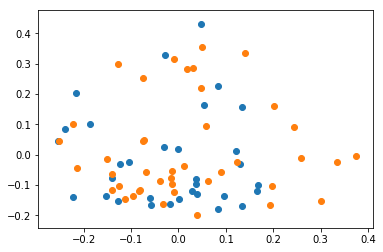

In [1994]:
unt = 32
plt.scatter(eigenvectors[:,3][:unt]*np.sqrt(eigenvalues[0]), eigenvectors[:,4][:unt]*np.sqrt(eigenvalues[1]))
plt.scatter(eigenvectors[:,3][unt:]*np.sqrt(eigenvalues[0]), eigenvectors[:,4][unt:]*np.sqrt(eigenvalues[1]))

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

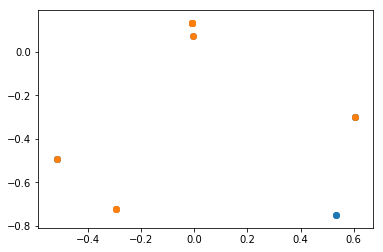

0
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
1
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
4
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
6
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!


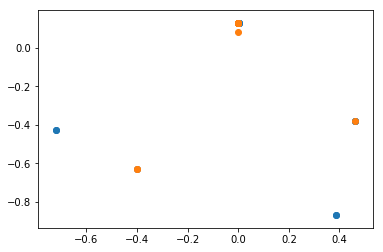

0
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
15
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!


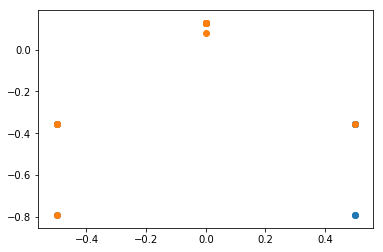

0
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
3
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
9
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
13
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

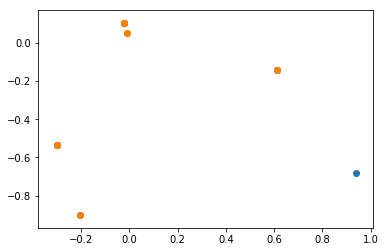

0
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
4
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
5
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
11
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
13
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!


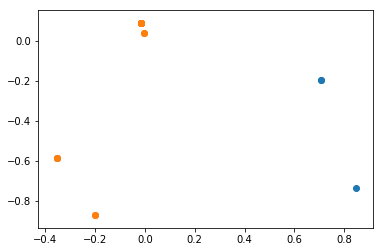

0
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
12
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
13
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter = 3!
counter =

In [1676]:
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=RANDOM_STATE)
scores = []
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
k=2
for train_index, test_index in skf.split(data, targets_p):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets_p[train_index], targets_p[test_index]
    K = make_kernel_matrix(X_train, len(train_index))
    k=2
    n_components = k
    eigenvalues, eigenvectors = linalg.eigh(center_kernel_matrix(K), eigvals=(K.shape[0] - n_components, K.shape[0] - 1))
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = np.zeros((len(train_index), k))
    new_features_test = np.zeros((len(test_index), k))
    new_features_train = eigenvectors
    plt.scatter(eigenvectors[:,0][0:32]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][0:32]*np.sqrt(eigenvalues[1]))
    plt.scatter(eigenvectors[:,0][32:]*np.sqrt(eigenvalues[0]), eigenvectors[:,1][32:]*np.sqrt(eigenvalues[1]))
    plt.show()
    for i in range(len(test_index)):
        print(i)
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    print('READY')
    nb_clf = XGBClassifier()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    score_train = accuracy_score(y_train, nb_clf.predict(eigenvectors))
    scores.append([score,score_train])

In [1677]:
scores

[[0.5, 0.896551724137931],
 [0.4375, 0.8793103448275862],
 [0.5, 0.9166666666666666],
 [0.5714285714285714, 0.85],
 [0.6428571428571429, 0.95]]

In [810]:

new_features_train = np.zeros((len(data), k))
new_features_test = np.zeros((len(test_index), k))
# for i in range(len(data)):
#     new_features_train[i] = get_projections(data[i], data, eigenvectors, K)
#     print(i)

In [705]:
new_features_train[:,0] - X_kpca[:,0]

array([ 0.08343032, -0.24650857, -0.30365539, -0.08767431,  0.03519846,
       -0.16367335,  0.03687604, -0.18676289, -0.24547235, -0.20629954,
       -0.05913331, -0.17662925, -0.12739075, -0.16204238, -0.03878631,
        0.18721511, -0.13820616, -0.04982918,  0.16083962, -0.1936849 ,
        0.16664539,  0.10977267,  0.02298974,  0.22032696, -0.17063464,
        0.24243466, -0.02436904,  0.01103328, -0.07923964,  0.55149265,
        0.30988874,  0.8360554 , -0.23506971, -0.29983587,  0.06577761,
       -0.04763041, -0.47038656, -0.32540151, -0.01114438, -0.44460687,
       -0.01869625, -0.03692505, -0.08831781,  0.16151416,  0.07784028,
       -0.0498924 ,  0.06788554,  0.11130864, -0.02326822, -0.12349601,
       -0.05533758,  0.18226129, -0.12668711,  0.19512416,  0.14256185,
       -0.07148256,  0.19048148,  0.22850396, -0.26727769, -0.10657127,
       -0.09611773, -0.0468976 ,  0.39248752,  0.09121625, -0.24511438,
        0.04283573,  0.29571664,  0.38142147, -0.02640895,  0.29

In [722]:
kpca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=True, gamma=12.5)
X_kpca = kpca.fit_transform(data_DA)


In [730]:
kpca.X_transformed_fit_[:,1]

array([-1.05372461e-01, -1.56228780e-01, -2.58453820e-01, -6.67058727e-02,
       -1.50780107e-01, -4.64128769e-02, -5.95016013e-02, -1.21148556e-01,
       -2.03845823e-01, -1.29617855e-01, -6.88870227e-02, -1.43050848e-01,
       -1.60518564e-02, -3.64939101e-02, -1.20276735e-01,  4.04972438e-02,
       -8.13897017e-02,  2.00159360e-01,  2.53897745e-02, -9.01940152e-02,
       -2.25822954e-02,  5.64262334e-02, -5.25172503e-02,  1.52735312e-02,
        1.81073922e-02,  1.23411988e-01, -4.05716454e-02, -6.70600839e-02,
       -3.26346237e-02,  4.00106045e-01,  2.43711376e-01,  5.22700114e-01,
       -1.57802817e-01, -4.06547228e-02,  1.26392596e-02, -2.84183072e-02,
       -1.22874342e-01,  5.93134710e-02, -1.79673385e-01,  6.96521625e-02,
       -1.39396428e-01, -6.36169058e-02, -9.33869221e-02,  1.34671192e-01,
       -3.72901959e-04, -5.11278489e-02, -2.69259186e-02,  3.85057115e-02,
       -1.27467397e-01, -4.11546001e-02,  5.23409499e-03,  8.90928306e-02,
       -1.05657006e-01,  

In [725]:
kpca.alphas_[:,1] * np.sqrt(kpca.lambdas_[1])

array([-1.05372461e-01, -1.56228780e-01, -2.58453820e-01, -6.67058727e-02,
       -1.50780107e-01, -4.64128769e-02, -5.95016013e-02, -1.21148556e-01,
       -2.03845823e-01, -1.29617855e-01, -6.88870227e-02, -1.43050848e-01,
       -1.60518564e-02, -3.64939101e-02, -1.20276735e-01,  4.04972438e-02,
       -8.13897017e-02,  2.00159360e-01,  2.53897745e-02, -9.01940152e-02,
       -2.25822954e-02,  5.64262334e-02, -5.25172503e-02,  1.52735312e-02,
        1.81073922e-02,  1.23411988e-01, -4.05716454e-02, -6.70600839e-02,
       -3.26346237e-02,  4.00106045e-01,  2.43711376e-01,  5.22700114e-01,
       -1.57802817e-01, -4.06547228e-02,  1.26392596e-02, -2.84183072e-02,
       -1.22874342e-01,  5.93134710e-02, -1.79673385e-01,  6.96521625e-02,
       -1.39396428e-01, -6.36169058e-02, -9.33869221e-02,  1.34671192e-01,
       -3.72901959e-04, -5.11278489e-02, -2.69259186e-02,  3.85057115e-02,
       -1.27467397e-01, -4.11546001e-02,  5.23409499e-03,  8.90928306e-02,
       -1.05657006e-01,  

In [713]:
kpca.alphas_[:,1] - eigenvectors[:,0]/np.sqrt(eigenvalues[0])

array([-1.56274994e-02, -2.31698600e-02, -3.83305741e-02, -9.89296423e-03,
       -2.23617823e-02, -6.88336593e-03, -8.82451858e-03, -1.79672087e-02,
       -3.02318125e-02, -1.92232670e-02, -1.02164446e-02, -2.12154772e-02,
       -2.38060661e-03, -5.41231128e-03, -1.78379112e-02,  6.00603467e-03,
       -1.20706825e-02,  2.96850833e-02,  3.76548752e-03, -1.33764260e-02,
       -3.34911802e-03,  8.36841924e-03, -7.78868872e-03,  2.26517534e-03,
        2.68545746e-03,  1.83028921e-02, -6.01706898e-03, -9.94549632e-03,
       -4.83995114e-03,  5.93386254e-02,  3.61441628e-02,  7.75202140e-02,
       -2.34033012e-02, -6.02938995e-03,  1.87449378e-03, -4.21464085e-03,
       -1.82231552e-02,  8.79661750e-03, -2.66468648e-02,  1.03299204e-02,
       -2.06735003e-02, -9.43484806e-03, -1.38499572e-02,  1.99727136e-02,
       -5.53040624e-05, -7.58263043e-03, -3.99330882e-03,  5.71067601e-03,
       -1.89043385e-02, -6.10352537e-03,  7.76254210e-04,  1.32131123e-02,
       -1.56696995e-02,  

In [645]:
new_features_train.sum(axis = 0)

array([-1.34892097e-14,  4.75314232e-15])

In [634]:
np.linalg.norm(kpca.alphas_[:,0])/kpca.lambdas_[1]

0.6705857689061828

In [623]:
np.linalg.norm(eigenvectors[:,0])

0.6705857689061828

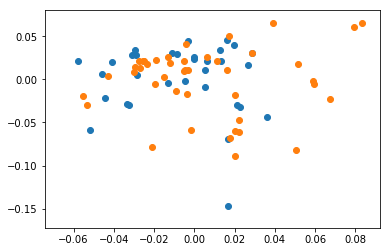

In [721]:
eigenvalues

array([3.08790032, 4.26128299])

control sum:  32
ill sum:  44
control :  0
ill :  0


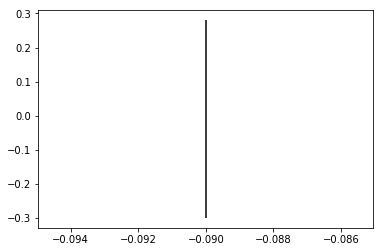

In [379]:
tr = -0.09
print('control sum: ', 32)
print('ill sum: ', 76-32)
print('control : ' , np.sum(new_features_train[:, 1][:32] > tr))
print('ill : ' , np.sum(new_features_train[:, 1][32:] > tr))
plt.vlines(tr, ymin=-0.3, ymax=0.28)
plt.scatter(new_features_train[:,0][0:32], new_features_train[:,1][0:32])
plt.scatter(new_features_train[:,0][32:], new_features_train[:,1][32:])

18

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=RANDOM_STATE)
scores = []
data_DA, data_HB, data_SC = pupil_hists_DA, pupil_hists_HB, pupil_hists_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
k=2
for train_index, test_index in skf.split(data, targets_p):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets_p[train_index], targets_p[test_index]
    K = make_kernel_matrix(X_train, len(train_index))
    eigenvalues_1, eigenvectors_1 = np.linalg.eigh(center_kernel_matrix(K))
    eigenvalues = eigenvalues_1[len(train_index)- k:]
    eigenvectors = eigenvectors_1[:, len(train_index)- k: ]
    print(eigenvalues)
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = np.zeros((len(train_index), k))
    new_features_test = np.zeros((len(test_index), k))
    for i in range(len(train_index)):
        new_features_train[i] = get_projections(X_train[i], X_train, eigenvectors, K)
        print(i)
    for i in range(len(test_index)):
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    print('READY')
    nb_clf = GaussianNB()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    scores.append(score)

[1.97979032 8.61809776]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
READY
[2.81486871 9.20332066]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
READY
[2.7998573  8.44477381]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 

In [122]:
data_DA, data_HB, data_SC = pupil_hists_DA, pupil_hists_HB, pupil_hists_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
data = np.array(data)
targets_p = np.array(targets_p)
k=2
K = make_kernel_matrix(make_data_for_kernel(den_maps_DA,den_maps_HB,den_maps_SC), 75)
eigenvalues_1, eigenvectors_1 = np.linalg.eigh(center_kernel_matrix(K))
eigenvalues = eigenvalues_1[len(data)- k:]
eigenvectors = eigenvectors_1[:, len(data)- k:]

In [123]:
for idx, eigenvalue in enumerate(eigenvalues):
    eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
new_features_train = np.zeros((len(data), k))
new_features_test = np.zeros((len(test_index), k))
for i in range(len(data)):
    new_features_train[i] = get_projections(data[i], data, eigenvectors, K)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


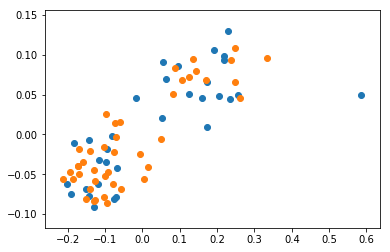

In [125]:
nb_clf = GaussianNB()
nb_clf.fit(new_features_train, targets_p)
score = accuracy_score(targets_p, nb_clf.predict(new_features_train))
score

0.6266666666666667

array([[ 252.5, -181.4,   93.9, ...,    0. ,    0. ,    0. ],
       [-239.6, -249.5,  257.7, ...,    0. ,    0. ,    0. ]])

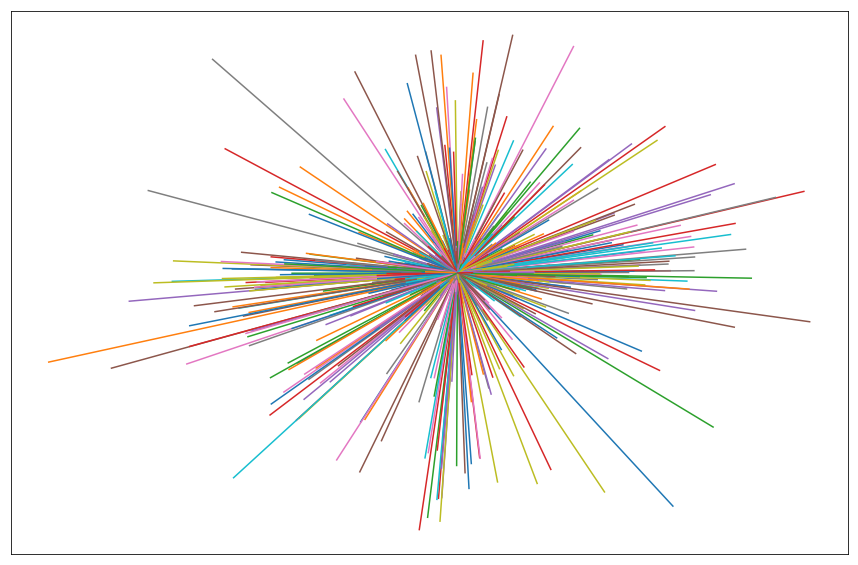

In [1981]:
data = pd.read_csv('EyeMovementsGlaucomaDataset' + '/_suc_delta_' + 'C020.csv')
sac_coords = make_saccades_picture(data, save_pic=True)
sac_coords

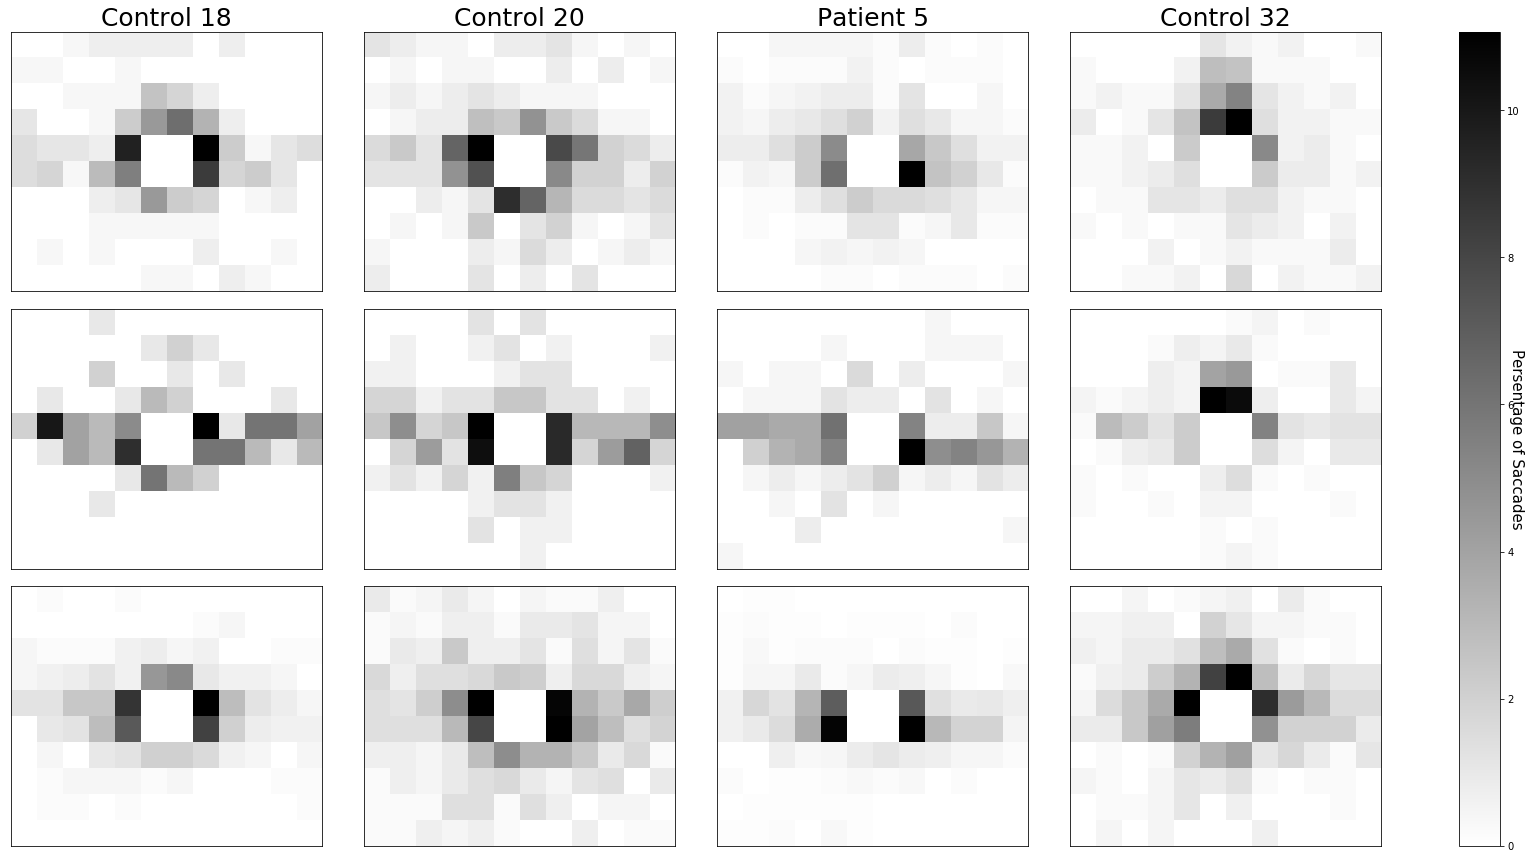

In [1988]:
fig, axes = plt.subplots(3, 4, figsize=(22, 12))

axes[0, 0].imshow(den_maps_DA[17].reshape(10,12)*100, cmap = "binary")
axes[0, 0].set_title('Control 18', fontsize=25)
axes[0, 0].set_yticks(())
axes[0, 0].set_xticks(())
axes[1, 0].imshow(den_maps_HB[17].reshape(10,12)*100, cmap = "binary")
axes[1, 0].set_yticks(())
axes[1, 0].set_xticks(())
axes[2, 0].imshow(den_maps_SC[17].reshape(10,12)*100, cmap = "binary")
axes[2, 0].set_yticks(())
axes[2, 0].set_xticks(())

axes[0, 1].imshow(den_maps_DA[19].reshape(10,12)*100, cmap = "binary")
axes[0, 1].set_title('Control 20', fontsize=25)
axes[0, 1].set_yticks(())
axes[0, 1].set_xticks(())
heatmap=axes[1, 1].imshow(den_maps_HB[19].reshape(10,12)*100, cmap = "binary")
axes[1, 1].set_yticks(())
axes[1, 1].set_xticks(())
axes[2, 1].imshow(den_maps_SC[19].reshape(10,12)*100, cmap = "binary")
axes[2, 1].set_yticks(())
axes[2, 1].set_xticks(())

axes[0, 2].imshow(den_maps_DA[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[0, 2].set_title('Patient 5', fontsize=25)
axes[0, 2].set_yticks(())
axes[0, 2].set_xticks(())
heatmap=axes[1, 2].imshow(den_maps_HB[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[1, 2].set_yticks(())
axes[1, 2].set_xticks(())
axes[2, 2].imshow(den_maps_SC[31 + 5].reshape(10,12)*100, cmap = "binary")
axes[2, 2].set_yticks(())
axes[2, 2].set_xticks(())

axes[0, 3].imshow(den_maps_DA[31].reshape(10,12)*100, cmap = "binary")
axes[0, 3].set_title('Control 32', fontsize=25)
axes[0, 3].set_yticks(())
axes[0, 3].set_xticks(())
axes[1, 3].imshow(den_maps_HB[31].reshape(10,12)*100, cmap = "binary")
axes[1, 3].set_yticks(())
axes[1, 3].set_xticks(())
axes[2, 3].imshow(den_maps_SC[31].reshape(10,12)*100, cmap = "binary")
axes[2, 3].set_yticks(())
axes[2, 3].set_xticks(())


fig.tight_layout()
cbar = fig.colorbar(heatmap, ax=axes, orientation='vertical', fraction=.035)
cbar.set_label('Persentage of Saccades', rotation=270, fontsize=15)
plt.savefig('dzis_gay.png', dpi=200)

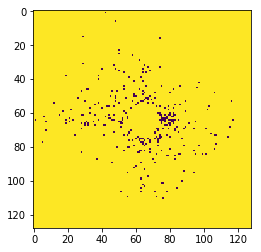

In [1983]:
plt.imshow(pictures_DA[0])

In [47]:
# main func 
path = 'EyeMovementsGlaucomaDataset/Data/Clinical/ParticipantDetails.csv'
clinic = pd.read_csv(path)
clinic = clinic.sort_values(by=['ID'])
clinic = clinic.reset_index(drop = True)
clinic = clinic.drop(['Left MD','Right MD'],axis = 1)

path = 'EyeMovementsGlaucomaDataset/Data/Gaze/Processed/Control'
control_path = path 
files = [f for f in os.listdir(control_path) if f.endswith('.csv')]
dataset = clinic
files.sort()

path_read = path
path_write = 'EyeMovementsGlaucomaDataset/'

dataset_DA, dataset_HB, dataset_SC, targets_d = make_dataset(files,features, path_read,path_write)
pictures_DA = []
pictures_HB = []
pictures_SC = []
den_maps_DA = []
den_maps_HB = []
den_maps_SC = []
targets_p = []
min_saccade = 5
size = 64
n_rows = 10
n_columns = 20
 
for f in files:
    data =  pd.read_csv(path_write + '/_suc_delta_' + f)
    picture_DA, picture_HB, picture_SC = make_picture(data, min_saccade, size)
    den_map_DA, den_map_HB, den_map_SC = make_density_map(data, min_saccade, n_rows, n_columns)
    pictures_DA.append(picture_DA) 
    pictures_HB.append(picture_HB) 
    pictures_SC.append(picture_SC) 
    
    den_maps_DA.append(den_map_DA)
    den_maps_HB.append(den_map_HB)
    den_maps_SC.append(den_map_SC)
    if f[0] == 'C':
        targets_p.append(0)
    else:
        targets_p.append(1)

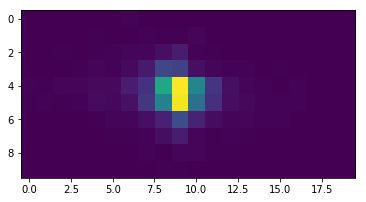

In [48]:
pictures_all = []
for i in range(len(pictures_DA)):
    pictures_all.append((pictures_DA[i] * pictures_HB[i] * pictures_SC[i])/255**3)

# plt.imshow(pictures_all[2])
den_maps_all = []
for i in range(len(den_maps_DA)):
    den_maps_all.append(den_maps_DA[i] + den_maps_HB[i] + den_maps_SC[i])
    
plt.imshow(den_maps_all[0])

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
if str(device) == 'cuda:0':
    print('Device name: {}'.format(torch.cuda.get_device_name(0)))

Device: cpu


In [13]:
class GlaucomaDataset(Dataset):
    """Data on Eye movements of Glaucoma Patients: a Case control Study"""

    def __init__(self, root_dir='EyeMovementsGlaucomaDataset', transform=None,
                 pictures_array=None, labels_array=None):
        """
        Args: 
            root_dir (string): Directory with all images.
        """
        self.pictures_array = pictures_array
        self.labels_array = labels_array
        self.transform = transform
        self.root_dir = root_dir
        self.pictures, self.labels = self._make_suc_delta_pictures()

    def __getitem__(self, idx):
        pic = np.asarray(self.pictures[idx])/255.
        pic = pic.astype(np.float64)
        pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
        pic = Image.fromarray(np.asarray(self.pictures[idx]))
        if self.transform:
            pic = self.transform(pic)
        return pic, torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    def _make_suc_delta_pictures(self):
        if self.pictures_array:
            return self.pictures_array, self.labels_array
        pictures = []
        labels = []
        size = 64
        for index, f in enumerate(files):
            if index == 60:
                break
            tempdata = pd.read_csv(self.root_dir + '/suc_delta/_suc_delta_' + f)
            if f[0] == 'C':
                labels.append(0)
            if f[0] == 'G':
                labels.append(1)
            pictures.append(255*np.ones((2*size, 2*size)))
            tempdata['delta X'] = (size - 1) * tempdata['delta X'] / max(tempdata['delta X'].max(), - tempdata['delta X'].min())
            tempdata['delta Y'] = (size - 1) * tempdata['delta Y'] / max(tempdata['delta Y'].max(), - tempdata['delta Y'].min())
            for i in range(tempdata.shape[0]):
                pictures[-1][size + int(tempdata['delta X'].iloc[i]), size + int(tempdata['delta Y'].iloc[i]) ] = 0
        return pictures, np.array(labels)
    
    def print_pic(self, idx):
        print(pictures[idx])
        return None
    

class GlaucomaDataset_Test(Dataset):
    """Data on Eye movements of Glaucoma Patients: a Case control Study"""

    def __init__(self, root_dir='EyeMovementsGlaucomaDataset', transform=None,
                pictures_array=None, labels_array=None):
        """
        Args: 
            root_dir (string): Directory with all images.
        """
        self.pictures_array = pictures_array
        self.labels_array = labels_array
        self.transform = transform
        self.root_dir = root_dir
        self.pictures, self.labels = self._make_suc_delta_pictures()
    
    def __getitem__(self, idx):
        pic = np.asarray(self.pictures[idx])/255.
        pic = pic.astype(np.float64)
        pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
        pic = Image.fromarray(np.asarray(self.pictures[idx]))
        if self.transform:
            pic = self.transform(pic)
        return pic, torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    def _make_suc_delta_pictures(self):
        if self.pictures_array:
            return self.pictures_array, self.labels_array
        pictures = []
        labels = []
        size = 64
        for index, f in enumerate(files):
            if index < 60:
                continue
            tempdata = pd.read_csv(self.root_dir + '/suc_delta/_suc_delta_' + f)
            if f[0] == 'C':
                labels.append(0)
            if f[0] == 'G':
                labels.append(1)
            pictures.append(255*np.ones((2*size, 2*size)))
            tempdata['delta X'] = (size - 1) * tempdata['delta X'] / max(tempdata['delta X'].max(), - tempdata['delta X'].min())
            tempdata['delta Y'] = (size - 1) * tempdata['delta Y'] / max(tempdata['delta Y'].max(), - tempdata['delta Y'].min())
            for i in range(tempdata.shape[0]):
                pictures[-1][size + int(tempdata['delta X'].iloc[i]), size + int(tempdata['delta Y'].iloc[i]) ] = 0
        return pictures, np.array(labels)
    
    def print_pic(self, idx):
        print(self.pictures[idx])
        return None
    
    
def set_random_seeds(seed_value=0, device=0):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_accuracy(model, dataloader, device=0):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)
    
def train(model, optimizer, train_size, train_loader, val_loader, batch_size, device, 
          scheduler=None, epochs_n=100, save_best=False):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = (train_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        if scheduler is not None:
            scheduler.step()
        model.train()

        learning_curve[epoch] = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].set_title('Loss values')
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if save_best == True:
                torch.save(model.state_dict(), './best_params.pt')
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve, label='Train')
        axes[1].plot(val_accuracy_curve, label='Validation')
        axes[1].legend()

        plt.tight_layout()
        plt.show()


class MyAwesomeNN(nn.Module):
    def __init__(self, inp_ch=1, outp_ch=2):
        super().__init__()
        self.stage1 = nn.Sequential(
            #!
            nn.Conv2d(in_channels=inp_ch, out_channels=5, kernel_size=9),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=2),
            #!
            nn.Conv2d(in_channels=5, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=4))
        
        self.stage2 = nn.Sequential(
            #!
            nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            #!
            nn.MaxPool2d(kernel_size=2),
            #!
            nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4),
            nn.BatchNorm2d(4),
            nn.ReLU())
            #!
            #nn.MaxPool2d(kernel_size=2))
        
        self.size = 2
        self.features = 40
        self.fc = nn.Sequential(
            nn.Linear(self.size*self.size*4, self.features),
            nn.ReLU(),
#            nn.Dropout(p=.65),
            nn.Linear(self.features, outp_ch))
            

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.fc(x.view(-1, self.size*self.size*4))
        return x

CONV2D
$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
\times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$$
$$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
\times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$$

MAXPOOL2D, stride == kernel_size
$$
H_{out} = \left\lfloor\frac{H_{in} + 2 * \text{padding[0]} - \text{dilation[0]}
\times (\text{kernel\_size[0]} - 1) - 1}{\text{stride[0]}} + 1\right\rfloor
$$
$$
W_{out} = \left\lfloor\frac{W_{in} + 2 * \text{padding[1]} - \text{dilation[1]}
\times (\text{kernel\_size[1]} - 1) - 1}{\text{stride[1]}} + 1\right\rfloor
$$

In [27]:
X_train, X_test, y_train, y_test = train_test_split(pictures_SC, targets_p, 
                                                    test_size=0.1, random_state=RANDOM_STATE)
print(y_test)

set_random_seeds(device=device)
batch_size = 2
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = GlaucomaDataset(transform=transform, pictures_array=X_train, labels_array=y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataset_test = GlaucomaDataset_Test(transform=transform, pictures_array=X_test, labels_array=y_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

[0, 1, 0, 0, 1, 1, 1, 1]


tensor(255.)
tensor(1)


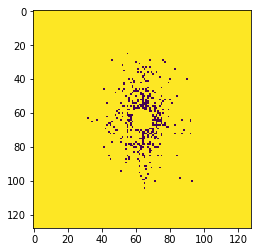

In [80]:
for X, y in train_loader:
    print(X[0][0][61][64])
    print(y[0])
    plt.imshow(np.array(X[0, 0, :, :]))
    plt.savefig('kekus.png')
    break

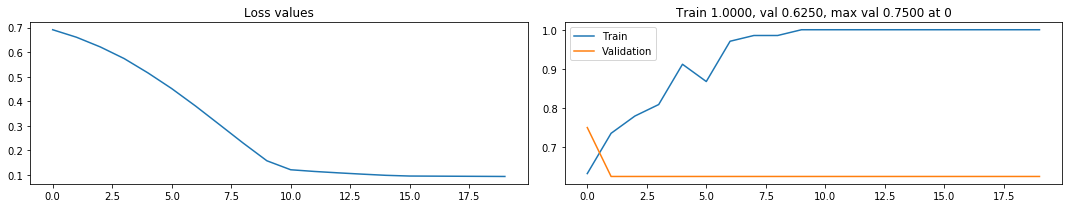







100%|██████████| 20/20 [00:23<00:00,  1.13s/it]







In [36]:
model = MyAwesomeNN().to(device)
adam_good_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(adam_good_optimizer, (10, 15, ), gamma=.1)
train(model, adam_good_optimizer, train_size=len(dataset_train), train_loader=train_loader, val_loader=test_loader, 
      batch_size=batch_size, device=device, scheduler=scheduler, epochs_n=20, save_best=True)

In [37]:
model = MyAwesomeNN().to(device)
model.load_state_dict(torch.load('best_params.pt'))
model.eval()

train_accuracy = get_accuracy(model, train_loader, device)
test_accuracy = get_accuracy(model, test_loader, device)
print('train_accuracy = {}'.format(train_accuracy))
print('test_accuracy = {}'.format(test_accuracy))

train_accuracy = 0.6323529411764706
test_accuracy = 0.75


In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(K)

def get_K(x, y, sigma=0.2):
    return np.exp(-1/(2*sigma**2)*(x+y)**2)
    
def get_projections(new_sample, train_samples, eigenvectors, K): 
    projections = []
    for eigen_idx in range(eigenvectors.shape[1]):
        projection = 0
        for element_idx, element in enumerate(train_samples):
            projection += eigenvectors[element_idx, eigen_idx] * centr_kernel_func(
                train_samples[element_idx], new_sample, train_samples, K)
        projections.append(projection)
    return np.asarray(projections)
            

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = []
data_DA, data_HB, data_SC = den_maps_DA, den_maps_HB, den_maps_SC
data = make_data_for_kernel(data_DA, data_HB, data_SC)
k=3
for train_index, test_index in skf.split(data, targets):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    K = make_kernel_matrix(data, len(train_index))
    eigenvalues, eigenvectors = np.linalg.eigh(K)
    for idx, eigenvalue in enumerate(eigenvalues):
        eigenvectors[:, idx] = eigenvectors[:, idx] / (eigenvalue * np.linalg.norm(eigenvectors[:, idx], ord=2))
    new_features_train = np.zeros((len(train_index), k))
    new_features_test = np.zeros((len(test_index), k))
    for i in range(len(train_index)):
        new_features_train[i] = get_projections(X_train[i], X_train, eigenvectors, K)
    for i in range(len(test_index)):
        new_features_test[i] = get_projections(X_test[i], X_train, eigenvectors, K)
    nb_clf = GaussianNB()
    nb_clf.fit(new_features_train, y_train)
    score = accuracy_score(y_test, nb_clf.predict(new_features_test))
    scores.append(score)

In [66]:
kek = np.array(np.array(0) / np.array(0))
np.isnan(kek)

True

In [ ]:
np.linalg.norm